In [27]:
# imports + Globals
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
import seaborn as sns
from joblib import dump

RANDOM_STATE = 42

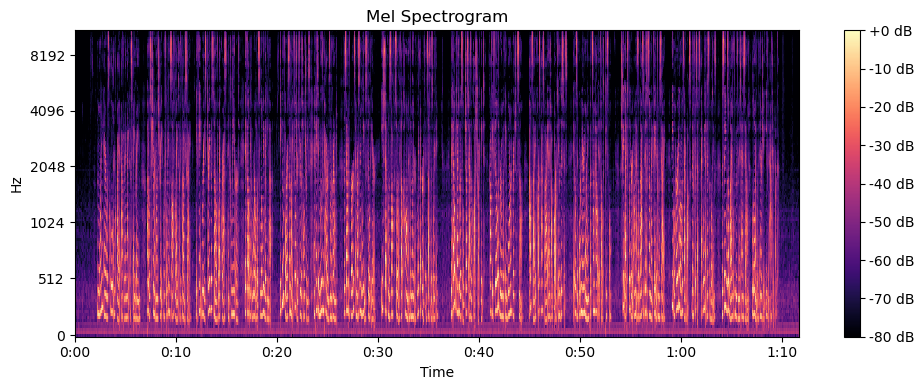

In [28]:
df = pd.read_csv("../data/audio/processed/audio_features.csv")
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# cool visual for presenttion
y, sr = librosa.load("../data/audio/raw/Lisa.wav", sr=22050)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [29]:
# slplit data into tain/testing + encode speaker names
x = df.drop(columns="speaker", axis=1)
y = df["speaker"]
y_encoded = df["speaker"].map({"Drake":0, "Melissa":1, "Lisa":2, "Dan":3, "David":4})
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.20, random_state=RANDOM_STATE)

Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_8638_f730444c1ec74d098abb3ea183ee210a_c95da8cb55044cfa97d3138a42ded33b for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_8638_b7eb7873dee34070ae7b8b7c854f69ac_1cf6889d3edd408582f43ba63597fb8a for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/minicon

Best F1 Score: 0.9773603007936809
Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 2, 'classifier__n_estimators': 200}
Test F1 (macro): 0.9821338366268172
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.96      1.00      0.98        24
           2       0.96      1.00      0.98        23
           3       1.00      0.95      0.98        21
           4       1.00      1.00      1.00        26

    accuracy                           0.98       116
   macro avg       0.98      0.98      0.98       116
weighted avg       0.98      0.98      0.98       116



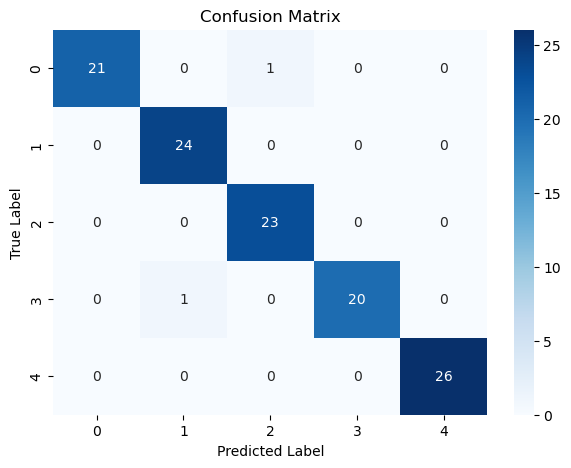

In [30]:
gb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])
    
gb_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [2, 3],
}

gb_search = GridSearchCV(gb_pipe, gb_grid, scoring="f1_macro", cv=5, n_jobs=-1)
gb_search.fit(x_train, y_train)
print(f"Best F1 Score: {gb_search.best_score_}")
print(f"Best Params: {gb_search.best_params_}")

gb_model = gb_search.best_estimator_
y_pred = gb_model.predict(x_test)

print("Test F1 (macro):", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [31]:
dump(gb_model, "speech_rec_model.pkl")

['speech_rec_model.pkl']

Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-8638-1bv3_rwx for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-8638-cq024rtm for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cl